# Signal Classification Using Spectrograms and Deep Learning

In this tutorial, we will introduce some basic methods for utilizing a Convolutional Neural Network (CNN) to process spectrograms created from Radio Frequency (RF) data. This tutorial was provided to NVidia Corporation in 2015 and has been used in their enterprise training tutorial series for several years. This version removes the dependency on DIGITS and uses only Keras and Tensorflow.  

### Introduction to signal detection
When monitoring radio frequency (RF) signals, or similar signals from sensors such as biomedical, temperature, etc., we are often interested in detecting certain signal “markers” or features. This can become a challenging problem when the signal-of-interest is degraded by noise. Traditional signal detection methods use a range of techniques such as energy detection, matched filtering, or other correlation-based processing techniques. Short-duration radio frequency (RF) events can be especially challenging to detect, since the useful data length is limited and long integration times are not possible. Weak signals that are short in duration are some of the most difficult to reliably detect (or even find). We will walk you through a simple approach using a Convolutional Neural Network (CNN) to tackle the traditional signal processing problem of detecting RF signals in noise.

### A little background information
Signal detection theory often assumes that a signal is corupted with additive white Gaussian noise (AWGN). This type of noise is common in the real world and the assumption makes mathematical analysis tractable. The detection of a signal in noise depends on the signal duration, amplitude, and the corresponding noise process. This becomes more difficult if correlated noise, or interfering signals, are also in the same band as the signal you wish to detect.

In this tutorial, we will assume no a-priori information about the parameters for the signal-of-interest. As input to the Convolutional Neural Network, we will utilize spectrograms computed from simulated Radio Frequency (RF) data using a common Fast Fourier Transform (FFT) based method. Taking the input data into the frequency domain as time-frequency grams, which are 2D representations just like images, allows us to visualize the energy of a signal over some pre-determined time duration and frequency bandwidth.

### The difficulty with real-world signals
For a single sinusoid in AWGN, finding the frequency bin with the maximum amplitude is a method for estimating signal frequency in a spectrogram. But real-world signals are often more complex, with frequency components that change with time, and creating a generalized signal detection algorithm becomes difficult. In this tutorial, we will look at one of these types of signals - Linear Frequency-Modulated (LFM) signals. In a follow-on tutorial we will explore Frequency-Hopped (FH) signals and multi-signal detection scenarios.

### Linear Frequency-Modulated Signals
A linear frequency-modulated (LFM), or chirp, signal is a signal that ramps up or down in frequency over some time frame. Its frequency changes with time based on its chirp rate. Chirps are used in many different systems for frequency response measurements and timing. RADAR systems use chirp signals due to the inherent large time-bandwith product available with coherent processing. Another common use is for automatic room equalization in home theater receivers, since chirps can excite a large frequency swath quickly. Chirps can also be used as “pilot” signals to denote the start of an incoming transmission, and more.

Figure 1 shows a high-SNR chirp as seen in a grayscale spectrogram (the format we will be using). Since the spectrogram consists of real numbers all > 0, we can map it to an image file by scaling the values appropriately. So we only need a single grayscale image channel. In this plot, the x axis is time and the y axis is frequency. Brightness is proportional to signal power.<br>

<p align="center">
<img src="images/figure2.png" alt="Drawing" style="width: 300px;"/>
</p>
<div align="center">Fig1. High-SNR chip spectrogram (grayscale).</div>
<br>

The above chirp (Figure 1) has a high SNR and is easy to detect with traditional signal processing algorithms. But when the environment contains other signals and noise, reliable detection becomes more difficult. Figure 2 shows an example spectrogram with some pulsed carrier waves (sinusoids) and a low-bitrate digital communication BPSK signal embedded in noise. <br>

<p align="center">
<img src="images/figure3.png" alt="Drawing" style="width: 300px;"/>
</p>
<div align="center">Fig2. Multiple signals and noise (x-axis is time, y-axis is frequency).</div>
<br>

In Figure 2 there is no chirp signal, just noise and other signals. This is similar to what “real-world” RF signals look like – combinations of signal classes with different strengths, all embedded in noise. Figure 3 consists of another spectrogram showing noise, interfering signals, and a weak chirp signal.
<br>

<p align="center">
<img src="images/figure4.png" alt="Drawing" style="width: 300px;"/>
</p>
<div align="center">Fig3. Weak chirp embedded in noise with other signals (x-axis is time, y-axis is frequency).</div>
<br>

In Figure 3 the chirp signal is several dB below the noise power in this frequency band. In fact, the signal-to-noise-ratio (SNR) for the chirp is -7 dB. Note that it is barely visible to the human eye. Traditional detection methods, without large amounts of integration and/or a prior signal information, fail consistently in detecting a weak signal like this. Moreover, since we have interfering signals that are sharing the same bandwidth as the chirp, the problem becomes even harder.

### What is this good for?
When monitoring RF signals, we want accurate detection of these types of signals, as a human cannot visually inspect all the data manually. For example, in the case of intelligent spectral monitoring or cognitive radio, we want something to autonomously analyze extraordinary amounts of signal data all the time. The question arises: Can we design a better process to help detect these weak signals?

# Deep Spectral Detection (DSD): Data and CNN Model
We will create a two-output convolutional neural network (CNN) that ingests a time/frequency signal spectrogram (i.e., image). The network will determine whether a chirp signal is present (class 0 - chip) or a frequency hopping signal is present (class 1 - hop), or no chirp or hop signal is present (class 2 - none). We have provided a training data set (i.e., RF Spectrograms) to that contain examples of chirp and hop signals in noise and interference. Note that interference could be other types of signals, such as BPSK, or QPSK modulated communications signals. However, we are only interested in detecting chirp or hop signal types in this example. The notebook can be easily extended to more signal types.

    - We started with an AlexNet model and pruned down the number of fully-connected layers.
    - The two fully connected layers were also reduced in size (less neurons).
    - Added droppout to reduce overfitting during training.

In [3]:
# Imports
#%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import PIL
import tensorflow as tf
import os

2025-06-05 03:32:31.246356: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 03:32:31.268751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 03:32:31.268772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 03:32:31.269498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 03:32:31.273725: I tensorflow/core/platform/cpu_feature_guar

In [4]:
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.layers import ReLU, Softmax, Reshape, GlobalAveragePooling2D

In [5]:
# email me at ohmdsp@geeemale.com to get access to my TF dataset.
train_dir = '/data/dsd_datasets/multi/train/'
test_dir =  '/data/dsd_datasets/multi/test/'

# Directory with our training images
train_chirp_dir = os.path.join(train_dir, 'chirp')
print ('Total chirp training images:', len(os.listdir(train_chirp_dir)))
train_hop_dir = os.path.join(train_dir, 'hop')
print ('Total hop training images:', len(os.listdir(train_hop_dir)))
train_noise_dir = os.path.join(train_dir, 'cw')
print ('Total noise training images:', len(os.listdir(train_noise_dir)))


# Directory with our validation images
validation_chirp_dir = os.path.join(test_dir, 'chirp')
print ('Total chirp validation images:', len(os.listdir(validation_chirp_dir)))
validation_hop_dir = os.path.join(test_dir, 'hop')
print ('Total hop validation images:', len(os.listdir(validation_hop_dir)))
validation_noise_dir = os.path.join(test_dir, 'cw')
print ('Total noise validation images:', len(os.listdir(validation_noise_dir)))

Total chirp training images: 5000
Total hop training images: 5000
Total noise training images: 5000
Total chirp validation images: 5000
Total hop validation images: 5000
Total noise validation images: 5000


In [6]:
files_chirp = [os.path.join(train_dir + 'chirp', file_i)
        for file_i in os.listdir(train_dir + 'chirp') if '.jpg' in file_i]
files_hop = [os.path.join(train_dir + 'hop', file_i)
        for file_i in os.listdir(train_dir + 'hop') if '.jpg' in file_i]
files_noise = [os.path.join(train_dir + 'cw', file_i)
        for file_i in os.listdir(train_dir + 'cw') if '.jpg' in file_i]

In [7]:
img1 = plt.imread(files_chirp[130])
img2 = plt.imread(files_hop[150])
img3 = plt.imread(files_noise[150])

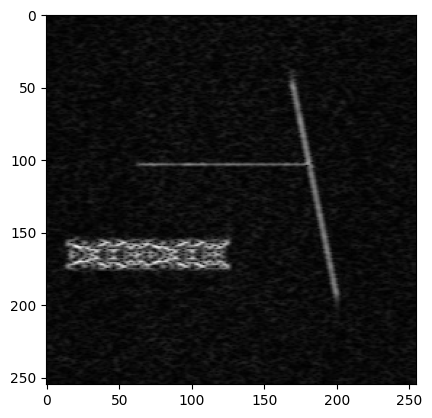

In [8]:
plt.imshow(img1,cmap='gray', vmin=0, vmax=255)

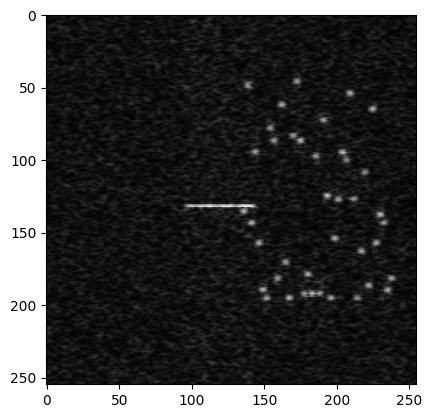

In [9]:
plt.imshow(img2,cmap='gray', vmin=0, vmax=255)

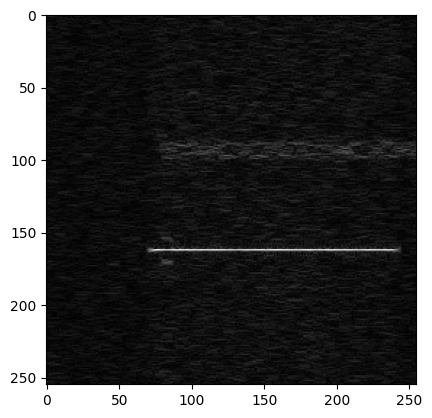

In [10]:
plt.imshow(img3,cmap='gray', vmin=0, vmax=255)

In [11]:
print(img1.shape)
print(np.min(img1), np.max(img1))

(255, 255)
0 255


In [12]:
image_size = 255
batch_size = 64

# Rescale all images by 1./255 and apply image augmentation to training images
train_datagen = ImageDataGenerator(            
                rescale=1./255,
                #rotation_range=10,
                #width_shift_range=0.05,
                #height_shift_range=0.05,
                #shear_range=0.05,
                #zoom_range=[0.9, 1.1],
                horizontal_flip=True,
                vertical_flip=False,
                fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                color_mode='grayscale',
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='categorical')

Found 15000 images belonging to 3 classes.


In [14]:
# Flow validation images in batches using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                test_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                shuffle=True,
                color_mode='grayscale',
                class_mode='categorical')

Found 15000 images belonging to 3 classes.


In [15]:
## Create Model for signal classification
def DSDNet(): 
    
    in_shp = (255,255,1)
    numOutputClasses = 3
    
    model = Sequential()
    #model.add(Reshape((255,255,1), input_shape = in_shp))
    
    model.add(Conv2D(96, (11, 11), strides=(4,4), input_shape = in_shp, activation='relu', kernel_initializer = 'glorot_uniform', padding = 'valid'))
    model.add(MaxPooling2D(pool_size = (3,3), strides=(2,2), padding='valid'))
    
    model.add(Conv2D(256, (5, 5), strides=(1,1),activation='relu', kernel_initializer = 'glorot_uniform', padding = 'valid'))
    model.add(MaxPooling2D(pool_size = (3,3), strides=(2,2), padding='valid'))
    
    model.add(Conv2D(384, (3, 3), activation='relu', kernel_initializer = 'glorot_uniform', padding = 'valid')) 
    #model.add(Conv2D(384, (3, 3), activation='relu', kernel_initializer = 'glorot_uniform', padding = 'valid'))  
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer = 'glorot_uniform', padding = 'valid'))
    model.add(MaxPooling2D(pool_size = (3,3), strides=(2,2), padding='valid'))
   

    model.add(Flatten())
    #model.add(Dense(9216, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(numOutputClasses,activation='softmax'))
      
    return model

In [16]:
model = DSDNet()

2025-06-05 03:32:32.701637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-05 03:32:32.705348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-05 03:32:32.705467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Let's take a look at the base model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         8

In [19]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    #class_weight=class_weight,
                    workers=4,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    use_multiprocessing = False)

Epoch 1/10


2025-06-05 03:32:39.268505: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-06-05 03:32:39.893081: I external/local_xla/xla/service/service.cc:168] XLA service 0x77d0e91b6500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-05 03:32:39.893093: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2025-06-05 03:32:39.896200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749094359.939447   13646 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 [==============================] - 13s 46ms/step - loss: 0.7294 - accuracy: 0.6121 - val_loss: 0.2424 - val_accuracy: 0.9137
Epoch 2/10
234/234 [==============================] - 10s 43ms/step - loss: 0.2501 - accuracy: 0.9042 - val_loss: 0.2575 - val_accuracy: 0.9062
Epoch 3/10
234/234 [==============================] - 10s 43ms/step - loss: 0.1946 - accuracy: 0.9272 - val_loss: 0.1926 - val_accuracy: 0.9267
Epoch 4/10
234/234 [==============================] - 10s 43ms/step - loss: 0.1532 - accuracy: 0.9450 - val_loss: 0.1002 - val_accuracy: 0.9652
Epoch 5/10
234/234 [==============================] - 10s 43ms/step - loss: 0.1373 - accuracy: 0.9510 - val_loss: 0.0905 - val_accuracy: 0.9673
Epoch 6/10
234/234 [==============================] - 10s 43ms/step - loss: 0.1194 - accuracy: 0.9581 - val_loss: 0.0676 - val_accuracy: 0.9764
Epoch 7/10
234/234 [==============================] - 10s 43ms/step - loss: 0.1062 - accuracy: 0.9642 - val_loss: 0.0906 - val_accuracy: 0.9695
Epo

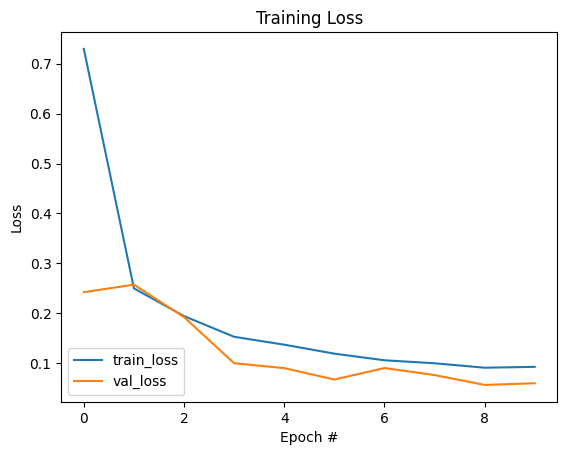

In [20]:
# plot the training loss and accuracy
N = epochs
#plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig("plot.png")

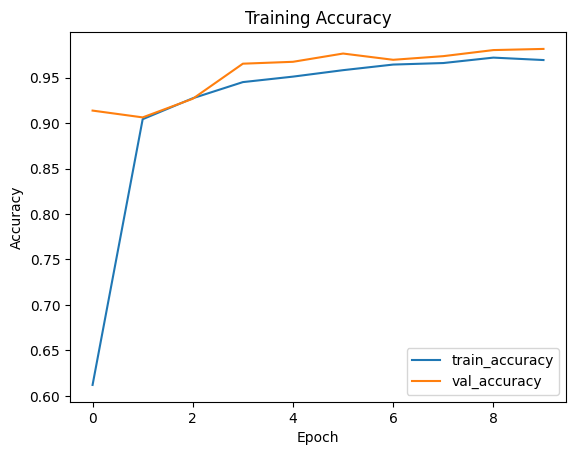

In [22]:
# plot the training loss and accuracy
N = len(history.history["accuracy"])

plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [23]:
# Normalize a confusion matrix
def normalize_conf_mtx(cm):
    norm_cm = []
    for i in cm:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            if a != 0:
                tmp_arr.append(float(j) / float(a))
            else:
                tmp_arr.append(0)

        norm_cm.append(tmp_arr)

    return np.array(norm_cm)

In [24]:
# Generate final results on test set by plotting confusion matrices
def create_conf_mtxs(y_true, y_pred):
    # Compute raw confusion matrix (input classes vs. output classes)
    cm = confusion_matrix(y_true, y_pred)    # from sklearn.metrics
    # Normalize it
    norm_cm = normalize_conf_mtx(cm)
    return cm, norm_cm

In [25]:
# Reinstantiate this for computing confusion matrix
# Flow validation images in batches using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                test_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                shuffle=False,
                color_mode='grayscale',
                class_mode='categorical')

Found 15000 images belonging to 3 classes.


In [26]:
# Generate final results on test set by plotting confusion matrices
eval_gen = validation_generator

Y_pred = model.predict_generator(eval_gen, validation_generator.n // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
y_pred = y_pred.astype(int)

Y_true = validation_generator.classes
y_true = Y_true[0:y_pred.shape[0]]

/tmp/ipykernel_13201/3875526742.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(eval_gen, validation_generator.n // batch_size)


In [27]:
print(confusion_matrix(y_pred, y_true))
cm, norm_cm = create_conf_mtxs(y_true, y_pred)

[[4776   38    8]
 [ 134 4956    0]
 [  90    6 4968]]


In [28]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

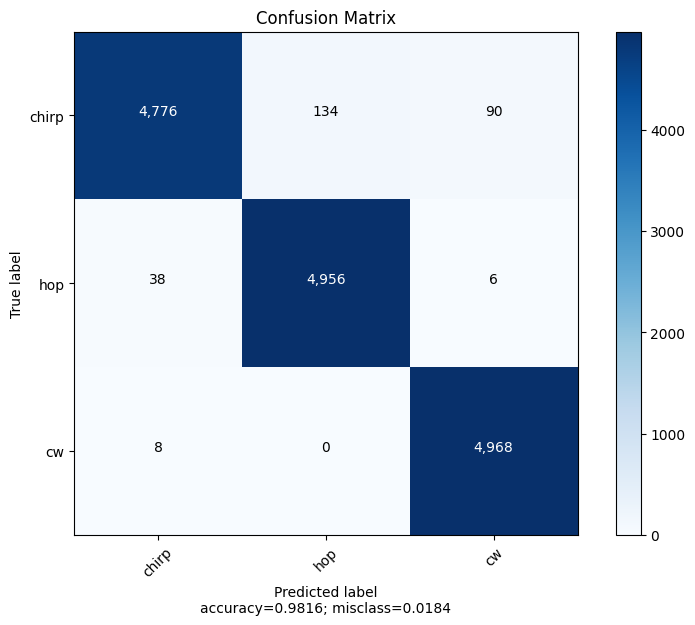

In [29]:
# Plot the output confusion matrix !!! why is this truncating the plot?
signal_types = ["chirp", "hop", "cw"]

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ["chirp", "hop", "cw"],
                      title        = "Confusion Matrix")

In [30]:
import pathlib

data_root = pathlib.Path(test_dir)
print(data_root)

/data/dsd_datasets/multi/test


In [31]:
## how many images are in test dataset
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

15000

In [32]:
all_image_paths[100:112]

['/data/dsd_datasets/multi/test/chirp/posex_n6.99db_4952.jpg',
 '/data/dsd_datasets/multi/test/cw/negex_4718.jpg',
 '/data/dsd_datasets/multi/test/chirp/posex_n6.99db_3689.jpg',
 '/data/dsd_datasets/multi/test/cw/negex_469.jpg',
 '/data/dsd_datasets/multi/test/chirp/posex_7.02db_4786.jpg',
 '/data/dsd_datasets/multi/test/cw/negex_2850.jpg',
 '/data/dsd_datasets/multi/test/hop/posex_n0.99db_2847.jpg',
 '/data/dsd_datasets/multi/test/chirp/posex_11.94db_2806.jpg',
 '/data/dsd_datasets/multi/test/cw/negex_4410.jpg',
 '/data/dsd_datasets/multi/test/cw/negex_4872.jpg',
 '/data/dsd_datasets/multi/test/chirp/posex_n6.99db_3873.jpg',
 '/data/dsd_datasets/multi/test/cw/negex_2641.jpg']

1/1 [==============================] - 0s 110ms/step


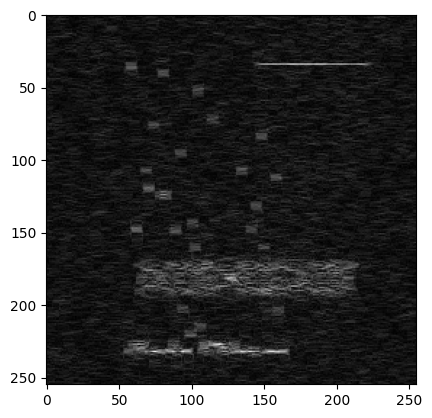

/data/dsd_datasets/multi/test/hop/posex_0.37db_2338.jpg
Probabililty[chirp, cw, hop] =  [[2.0792827e-08 5.2182223e-15 1.0000000e+00]]
1/1 [==============================] - 0s 11ms/step


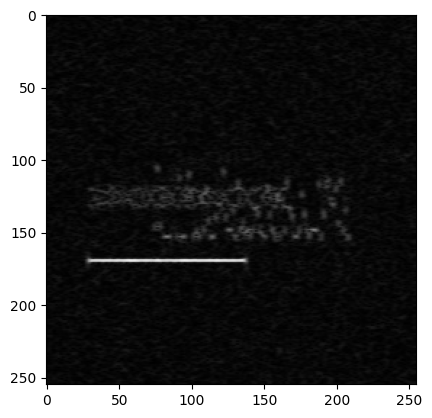

/data/dsd_datasets/multi/test/hop/posex_1.37db_2160.jpg
Probabililty[chirp, cw, hop] =  [[1.6370935e-10 9.0123712e-20 1.0000000e+00]]
1/1 [==============================] - 0s 10ms/step


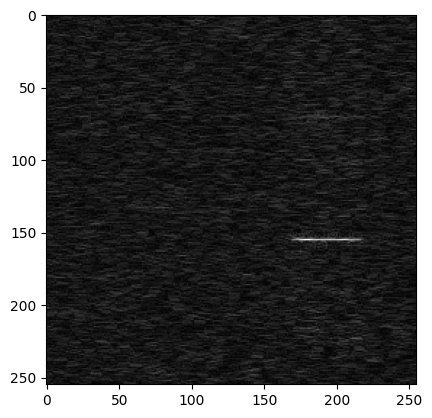

/data/dsd_datasets/multi/test/cw/negex_2062.jpg
Probabililty[chirp, cw, hop] =  [[9.4324769e-03 9.9052560e-01 4.1894036e-05]]
1/1 [==============================] - 0s 18ms/step


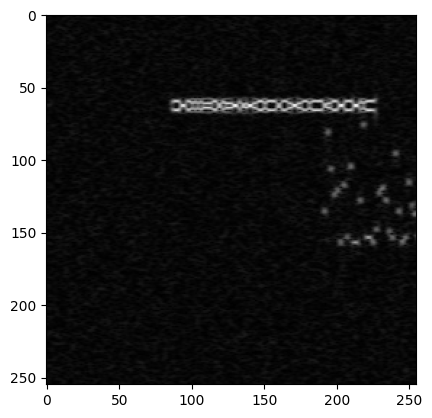

/data/dsd_datasets/multi/test/hop/posex_3.7db_4704.jpg
Probabililty[chirp, cw, hop] =  [[3.1778836e-08 4.0100924e-20 1.0000000e+00]]
1/1 [==============================] - 0s 10ms/step


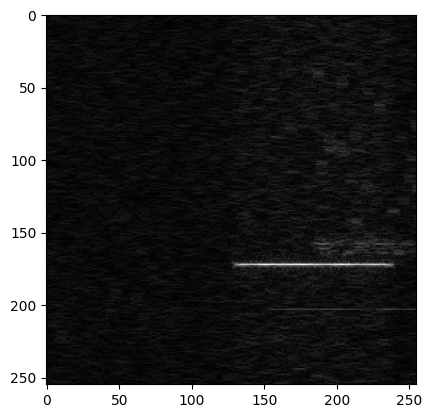

/data/dsd_datasets/multi/test/hop/posex_n1.56db_3326.jpg
Probabililty[chirp, cw, hop] =  [[0.07207032 0.00890686 0.91902286]]
1/1 [==============================] - 0s 10ms/step


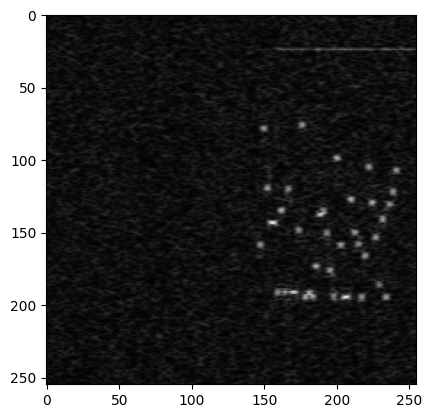

/data/dsd_datasets/multi/test/hop/posex_2.26db_2393.jpg
Probabililty[chirp, cw, hop] =  [[1.4812316e-26 0.0000000e+00 1.0000000e+00]]
1/1 [==============================] - 0s 10ms/step


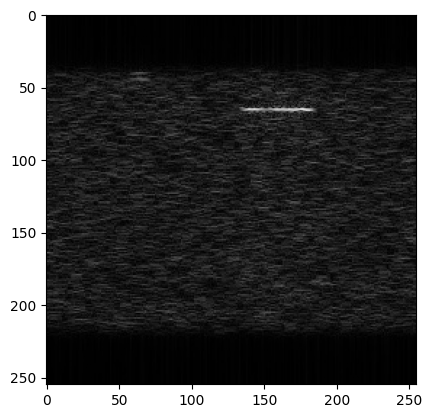

/data/dsd_datasets/multi/test/cw/negex_1148.jpg
Probabililty[chirp, cw, hop] =  [[1.1216090e-02 9.8873585e-01 4.8089347e-05]]
1/1 [==============================] - 0s 11ms/step


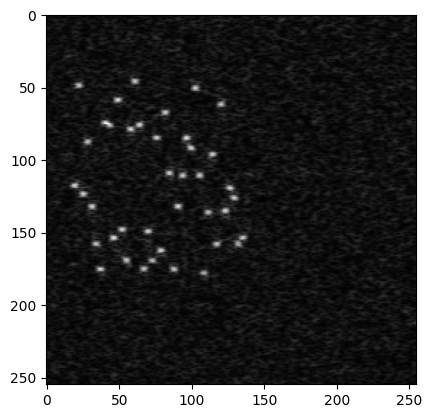

/data/dsd_datasets/multi/test/hop/posex_2.79db_1059.jpg
Probabililty[chirp, cw, hop] =  [[2.5799373e-38 0.0000000e+00 1.0000000e+00]]
1/1 [==============================] - 0s 10ms/step


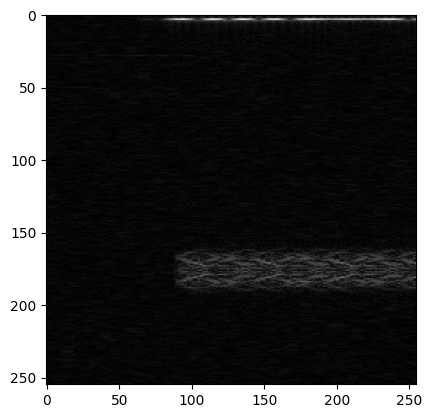

/data/dsd_datasets/multi/test/cw/negex_4901.jpg
Probabililty[chirp, cw, hop] =  [[1.5055698e-02 9.8483539e-01 1.0889485e-04]]
1/1 [==============================] - 0s 10ms/step


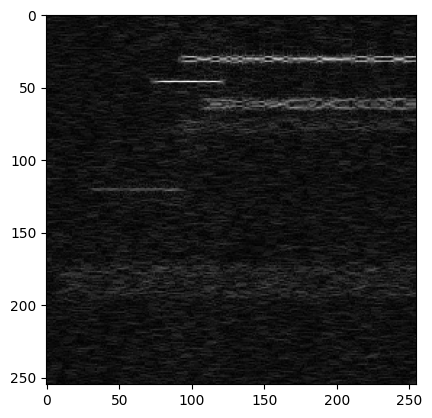

/data/dsd_datasets/multi/test/cw/negex_771.jpg
Probabililty[chirp, cw, hop] =  [[1.2551405e-02 9.8736537e-01 8.3233186e-05]]
1/1 [==============================] - 0s 11ms/step


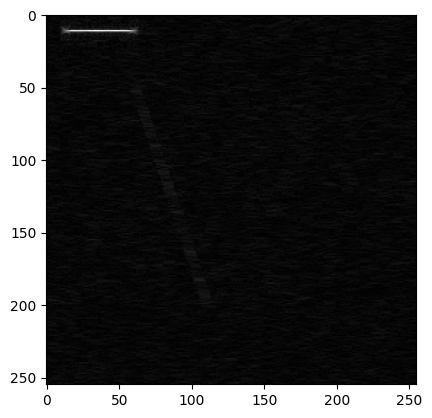

/data/dsd_datasets/multi/test/chirp/posex_n6.99db_2597.jpg
Probabililty[chirp, cw, hop] =  [[9.9995482e-01 3.6758556e-06 4.1424344e-05]]
1/1 [==============================] - 0s 12ms/step


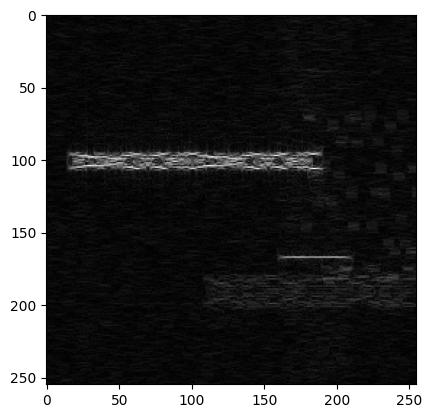

/data/dsd_datasets/multi/test/hop/posex_n0.81db_3455.jpg
Probabililty[chirp, cw, hop] =  [[0.11161979 0.00112501 0.88725525]]


In [34]:
for n in range(12):
    image_path = random.choice(all_image_paths)
    img = image.load_img(image_path, color_mode = "grayscale", target_size=(image_size, image_size))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    pred = model.predict(img_tensor)
    plt.imshow(img,cmap='gray', vmin=0, vmax=255)
    plt.show()
    print(image_path)
    print('Probabililty[chirp, cw, hop] = ', pred)

### Fine tuning the network model
- One way to fine tune the model is to create another training set with very low SNRs, around -4 to -8 dB.
- Copy this training set over to make a new database for this low SNR dataset.
- Train again using the new dataset.
- Fine tune on the pretrained model. Make the learning rate much smaller (/10 or /100) so the network cannot unlearn too much.
- Train on the low SNR data set for a handful of epochs. See if the network is able to learn more about low SNR cases.